# Forecasting Exercises

In this chapter, we're going to do a tour of forecasting exercises: that is, the set of operations, like slicing up time, that you might need to do when performing a forecast. Although there will be some code in this chapter, we're mostly laying the theoretical groundwork.

Let's start with some definitions. Features, or regressors, are labelled by $k = 0, \dots, K-1$ and time by $t = 0, \dots, T-1$. Note that this means there are $T$ time periods and $K$ features. We'll label different slices of time (or equivalently models trained on different data) by an index $\mu$ beginning from $\mu=1$, and we'll give these slices of time different labels: IS for in-sample and OS for out-of-sample. $f_\mu$ is the model trained on the $\mu$th set of in-sample data. The target variable (the number we are trying to forecast) is $\left\{y_{t+h}\right\}_{t=0}^{t=T-1}$, where $h$ is the number of time steps ahead we wish to forecast. Let $\left\{x_{tk}\right\}_{t=0}^{t=T-1}$ represent feature (or regressor) $k$. In general, a forecast implies $h>0$ (otherwise we're doing a nowcast).

Let's first do some setup for the rest of the chapter. We'll be using the **numpy**, **pandas**, **matplotlib**, and **plotnine** packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import (
    options,
    geom_tile,
    scale_size,
    scale_x_continuous,
    scale_y_continuous,
    ggplot,
    geom_point,
    aes,
)
from plotnine.scales import scale_fill_brewer

# Plot settings
plt.style.use(
    "https://github.com/aeturrell/coding-for-economists/raw/main/plot_style.txt"
)
options.set_option("figure_size", (6, 1.5))
options.set_option("dpi", 300)

# Set pandas max rows displayed for readability
pd.set_option("display.max_rows", 15)

## Two Period Forecast

The most simple forecast you can imagine is if we have two periods (each of which may be made up of more than one value of $t$). The important thing is that the $t$ in the first, "in-sample" period do not overlap with the $t$ in the second, "out-of-sample" period. That's because we *only want to use information in the in-sample period to forecast the out-of-sample period*. There are some cases where you may want to "forecast" the in-sample period, but if you're interested in the real-world performance of your forecast, this is the setup you need.

In this world of a single in-sample period and a single out-of-sample period, $\mu=1$, and we could get drop that notation and just use IS and OS. But we'll leave it in to make the contrast with what's to come clearer.

The exercise is to use a model, $f = f_{\mu=1}$, that is trained to predict $\{y_{t+h}, t:\mu_{\text{IS}}=1\}$ using $\{x_{tk}, t:\mu_{\text{IS}}=1\}$ so that it can do an out-of-sample forecast of $\{y_{t+h}, t:\mu_\text{OS}=1\}$ using $\{x_{tk}, t:\mu_{\text{OS}}=1\}$. It's actually easier to see it with a picture:

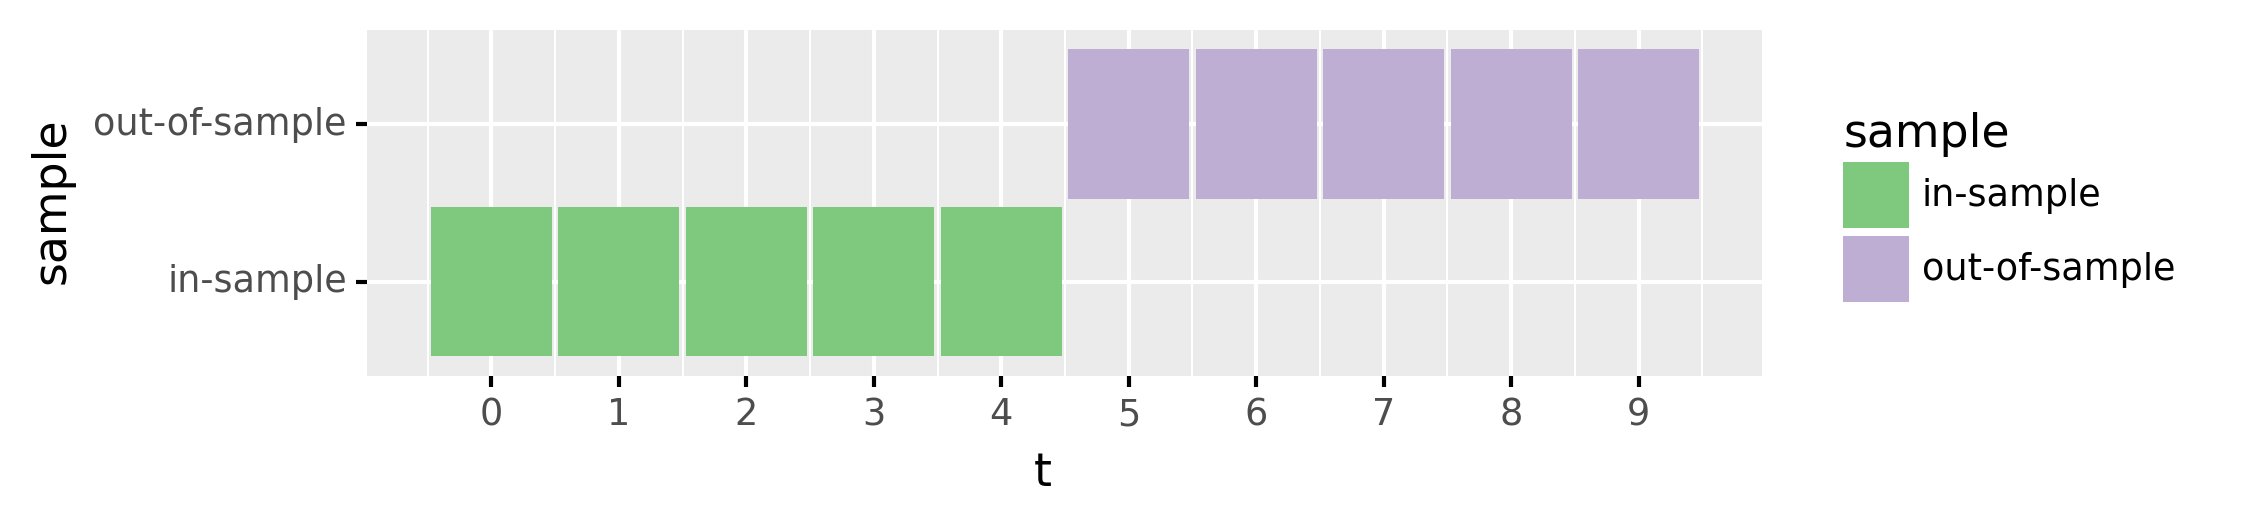

In [2]:
s = 1
alpha = 4
T = 10


def in_sample_block_e(mu, s, alpha, T):
    xf = pd.DataFrame({"t": np.arange(0, mu * s + alpha, s)})
    xf[r"$\mu$"] = [mu] * (mu * s + alpha - 0)
    xf["sample"] = "in-sample"
    return xf


def os_sample_block_e(mu, s, alpha, T):
    xf = pd.DataFrame({"t": np.arange(mu * s + alpha, T, s)})
    xf[r"$\mu$"] = [mu] * (T - (mu * s + alpha))
    xf["sample"] = "out-of-sample"
    return xf


def in_sample_block_r(mu, s, alpha, T):
    xf = pd.DataFrame({"t": np.arange((mu - 1) * s, mu * s + alpha, s)})
    xf[r"$\mu$"] = [mu] * (mu * s + alpha - (mu - 1) * s)
    xf["sample"] = "in-sample"
    return xf


def os_sample_block_r(mu, s, alpha, T):
    xf = pd.DataFrame({"t": np.arange(mu * s + alpha, T, s)})
    xf[r"$\mu$"] = [mu] * (T - (mu * s + alpha))
    xf["sample"] = "out-of-sample"
    return xf


(
    ggplot(aes("t", "sample", r"$\mu$"))
    + geom_tile(
        in_sample_block_e(1, s, alpha, T), aes(width=0.95, height=0.95, fill="sample")
    )
    + geom_tile(
        os_sample_block_e(1, s, alpha, T), aes(width=0.95, height=0.95, fill="sample")
    )
    + scale_x_continuous(breaks=range(T + 1))
    + scale_fill_brewer(type="qual", palette="Accent")
).draw();

In this case, the in-sample period runs from $t=0$ to $t=4$, while the out-of-sample period runs from $t=5$ to $t=9$. $T=10$.

Let's see how it works with some fake data, and we'll assume $h=3$ in this case.

In [3]:
import string

horizon = 3
num = 10 + horizon

df = pd.DataFrame(
    np.array(
        [
            range(num),
            list(string.ascii_lowercase)[:num],
            list(string.ascii_lowercase)[num : 2 * num],
        ]
    ).T,
    columns=["Time", "y", "x"],
)
df[r"$y_{t+h}$"] = df["y"].shift(-horizon)
df

,Time,y,x,$y_{t+h}$
0,0,a,n,d
1,1,b,o,e
2,2,c,p,f
3,3,d,q,g
4,4,e,r,h
5,5,f,s,i
6,6,g,t,j
7,7,h,u,k
8,8,i,v,l
9,9,j,w,m


What we have here is a dataset with a time index and y and x values. $y_{t+h}$ has been added as a feature by shifting the $y$ variable back by $h=3$ steps. We're not going to be able to predict those NaN values, so the first thing to do is to drop those variables. Second, we'll want to add in which parts are in-sample and which are out-of-sample.

In [4]:
df = df.dropna().copy()
df["sample"] = df["Time"].apply(lambda x: "IS" if int(x) < 5 else "OS")
df = df.set_index("Time")
df

,y,x,$y_{t+h}$,sample
Time,,,,
0,a,n,d,IS
1,b,o,e,IS
2,c,p,f,IS
3,d,q,g,IS
4,e,r,h,IS
5,f,s,i,OS
6,g,t,j,OS
7,h,u,k,OS
8,i,v,l,OS


Note how the sample can either be IS or OS-but not both.

Now, if we were doing a forecast, we'd select the IS part to do our initial model building by running something like

```python
model = ols.fit(X=df.loc[df["sample"]=="IS","x"],
                y=df.loc[df["sample"]=="IS",r"$y_{t+h}$"])
```

This would then be used to predict the out of sample values:

```python
y_t_plus_h_os = model.predict(X=df.loc[df["sample"]=="OS","x"])
```

To know how good the estimate was, we'd then compare it with the true value. Typically, a value like the root mean square error is used for this, given by

$$
{\displaystyle \operatorname {RMSE} ={\sqrt {\frac {\sum _{t=0}^{T-1}({\hat {y}}_{t+h}-y_{t+h})^{2}}{T}}}.}
$$

where $\hat{y}_{t+h}$ is the predicted value, equivalent to the object `y_t_plus_h_os` above.

### An Example Two Period Forecast

Let's see an example of this with some numerical data. Our dataframe needs to have our features, $x$, and target, $y_{t+h}$, in.

In [5]:
T = 10
window_size = 5
horizon = 3


df = pd.DataFrame(
    {
        "x": range(0, T + horizon),
        "y": [0] * horizon
        + list(range(0, window_size))
        + list(range(T - 1, window_size - 1, -1)),
    }
)
df["x"] = df["x"].astype(float)
# Bring y_{t+h} in line with feature x so that models always take data from the same row.
# Note that for a variable to be at t+h today, with h the horizon, we need to bring it *back* by h steps
df[r"$y_{t+h}$"] = df["y"].shift(-horizon)
# drop y so that we don't accidentally put it into model as a feature by mistake
df = df.drop("y", axis=1)
df

,x,$y_{t+h}$
0,0.0,0.0
1,1.0,1.0
2,2.0,2.0
3,3.0,3.0
4,4.0,4.0
5,5.0,9.0
6,6.0,8.0
7,7.0,7.0
8,8.0,6.0
9,9.0,5.0


As ever, it's good to look at your data so let's do a quick chart. Note that time and $x$ have the same values here, so this is also the time series of $y_{t+h}$.

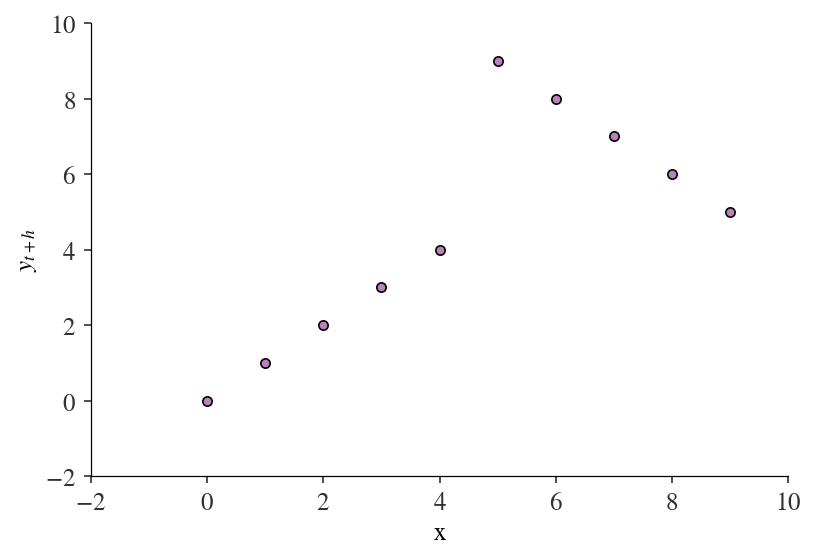

In [6]:
df.plot.scatter(x="x", y=r"$y_{t+h}$");

Okay, what could possibly go wrong! Let's now do our forecasting exercise. First, we train or fit the model. Note that *pandas* indexing is *inclusive*, so we run to `window_size-1` rather than `window_size` to pick up our 5 in-sample points

In [7]:
from sklearn.linear_model import LinearRegression

df = df.dropna().copy()
model = LinearRegression(fit_intercept=False).fit(
    X=df.loc[: window_size - 1, ["x"]], y=df.loc[: window_size - 1, [r"$y_{t+h}$"]]
)
# Make in-sample prediction. Note that the predictions of the model come out in
# an array of form [[a], [b], ...] so we flatten this to [a, b, ...]. Also, we pad
# the results we didn't predict with [None]
df[r"$\hat{y}_{t+h}^{\operatorname{IS}}$"] = list(
    model.predict(df.loc[: window_size - 1, ["x"]]).flatten()
) + [None] * (window_size)

Make out of sample prediction:

In [8]:
df[r"$\hat{y}_{t+h}^{\operatorname{OS}}$"] = [None] * (window_size) + list(
    model.predict(df.loc[window_size:, ["x"]]).flatten()
)
df

,x,$y_{t+h}$,$\hat{y}_{t+h}^{\operatorname{IS}}$,$\hat{y}_{t+h}^{\operatorname{OS}}$
0,0.0,0.0,0.0,NaN
1,1.0,1.0,1.0,NaN
2,2.0,2.0,2.0,NaN
3,3.0,3.0,3.0,NaN
4,4.0,4.0,4.0,NaN
5,5.0,9.0,NaN,5.0
6,6.0,8.0,NaN,6.0
7,7.0,7.0,NaN,7.0
8,8.0,6.0,NaN,8.0
9,9.0,5.0,NaN,9.0


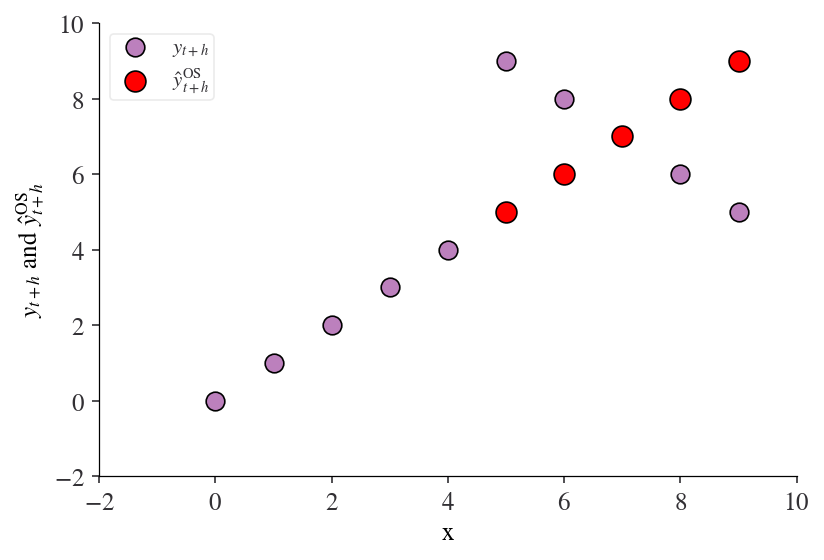

In [9]:
fig, ax = plt.subplots()
df.plot.scatter(x="x", y=r"$y_{t+h}$", ax=ax, label=r"$y_{t+h}$", s=80)
df.plot.scatter(
    x="x",
    y=r"$\hat{y}_{t+h}^{\operatorname{OS}}$",
    color="red",
    ax=ax,
    label=r"$\hat{y}_{t+h}^{\operatorname{OS}}$",
    s=100,
)
ax.set_ylabel(r"$y_{t+h}$ and $\hat{y}_{t+h}^{\operatorname{OS}}$")
ax.legend();

Oh dear, it doesn't look like our out-of-sample prediction did very well! Let's see what the RMSE error is for both the in-sample and out-of-sample prediction.

In [10]:
from sklearn.metrics import mean_squared_error


def get_rmse(df, fcast_name, target_name):
    # Get the index of the fcast
    index = df[fcast_name].dropna().index
    # only compare to values of target for which we have predictions:
    return np.sqrt(
        mean_squared_error(df.loc[index, fcast_name], df.loc[index, target_name])
    )


is_rmse = get_rmse(df, r"$\hat{y}_{t+h}^{\operatorname{IS}}$", r"$y_{t+h}$")
os_rmse = get_rmse(df, r"$\hat{y}_{t+h}^{\operatorname{OS}}$", r"$y_{t+h}$")

print(f"The rmse for in-sample best predictions is {is_rmse:.2f}")
print(f"The rmse for out-of-sample best predictions is {os_rmse:.2f}")

The rmse for in-sample best predictions is 0.00
The rmse for out-of-sample best predictions is 2.83


In this case - unsurprisingly given the big break in the trend of the time series - even though in-sample forecast is perfect, the *out-of-sample* forecast is terrible! If you ever have a situation where the OS RMSE is *lower* than the IS RMSE, it should ring alarm bells: it suggests something has gone wrong in the code.

### Adding a Lag

Quite frequently, you'll want to include lags in your forecast specification. Let's see how to do that in this simple, two-period forecast example. 

Just as forecasting a variable at $t+h$ means performing a `.shift(-h)` in order to bring the data together in the same row of a dataframe, so creating a feature (or regressor) that is a lag of another column will involve shifting the *other* way in time. So we're going to use `.shift(lag)`. Let's see it with some data:


In [11]:
T = 10
window_size = 5
horizon = 3


df = pd.DataFrame(
    {
        "x": range(-1, T + horizon),
        "y": list(range(-1 - horizon, window_size))
        + list(range(T - 1, window_size - 1, -1)),
    }
)
df["x"] = df["x"].astype(float)
# Bring y_{t+h} in line with feature x so that models always take data from the same row.
# Note that for a variable to be at t+h today, with h the horizon, we need to bring it *back* by h steps
df[r"$y_{t+h}$"] = df["y"].shift(-horizon)

# New part: create a single lag of y
df["lag_y"] = df["y"].shift(1)

df

,x,y,$y_{t+h}$,lag_y
0,-1.0,-4,-1.0,NaN
1,0.0,-3,0.0,-4.0
2,1.0,-2,1.0,-3.0
3,2.0,-1,2.0,-2.0
4,3.0,0,3.0,-1.0
5,4.0,1,4.0,0.0
6,5.0,2,9.0,1.0
7,6.0,3,8.0,2.0
8,7.0,4,7.0,3.0
9,8.0,9,6.0,4.0


Now you can see that there's an extra row we can't use (because we don't have the data for a lag of y from that time). As before, in practice, we'd drop y so that we didn't use it by mistake and also drop the top and tail rows that have nans in. We also reset the index to ensure it starts at 0 (by dropping the first row, we would otherwise lose the first index of zero):

In [12]:
df = df.drop("y", axis=1).dropna().reset_index(drop=True)
df

,x,$y_{t+h}$,lag_y
0,0.0,0.0,-4.0
1,1.0,1.0,-3.0
2,2.0,2.0,-2.0
3,3.0,3.0,-1.0
4,4.0,4.0,0.0
5,5.0,9.0,1.0
6,6.0,8.0,2.0
7,7.0,7.0,3.0
8,8.0,6.0,4.0
9,9.0,5.0,9.0


## Expanding Window

In an expanding window forecast exercise, multiple forecasts are made. In each, the in-sample period grows over time. Necessarily (given finite data), the out-of-sample period shrinks over time. The overall out-of-sample forecast is given by the unique union of the out-of-sample forecasts that are trained on the most information. To make this clear, let's first define it mathematically and then with a diagram.

We index the different forecasts (synoymous with different models $f_\mu$) by $\mu$. The starting size of the window will be $s + \alpha$ where $s$ is the step size and $\alpha$ is a parameter that adjusts window size. For arbitrary $z_t$, the $\mu$th in-sample slice of time series data is: 

$$
I^e_{\mu}(\vec{z}) = \left\{z_t  \right\}_{t=0}^{t=\mu\cdot s + \alpha -1}
$$

Applied to the features, this is the slice that will be used to train (aka fit) model $f_\mu$.

Likewise, the out-of-sample set is:

$$
O^e_{\mu}(\vec{z}) = \left\{z_t \right\}^{t=T-1}_{t=\mu\cdot s + \alpha}
$$

We can visualise this like so:

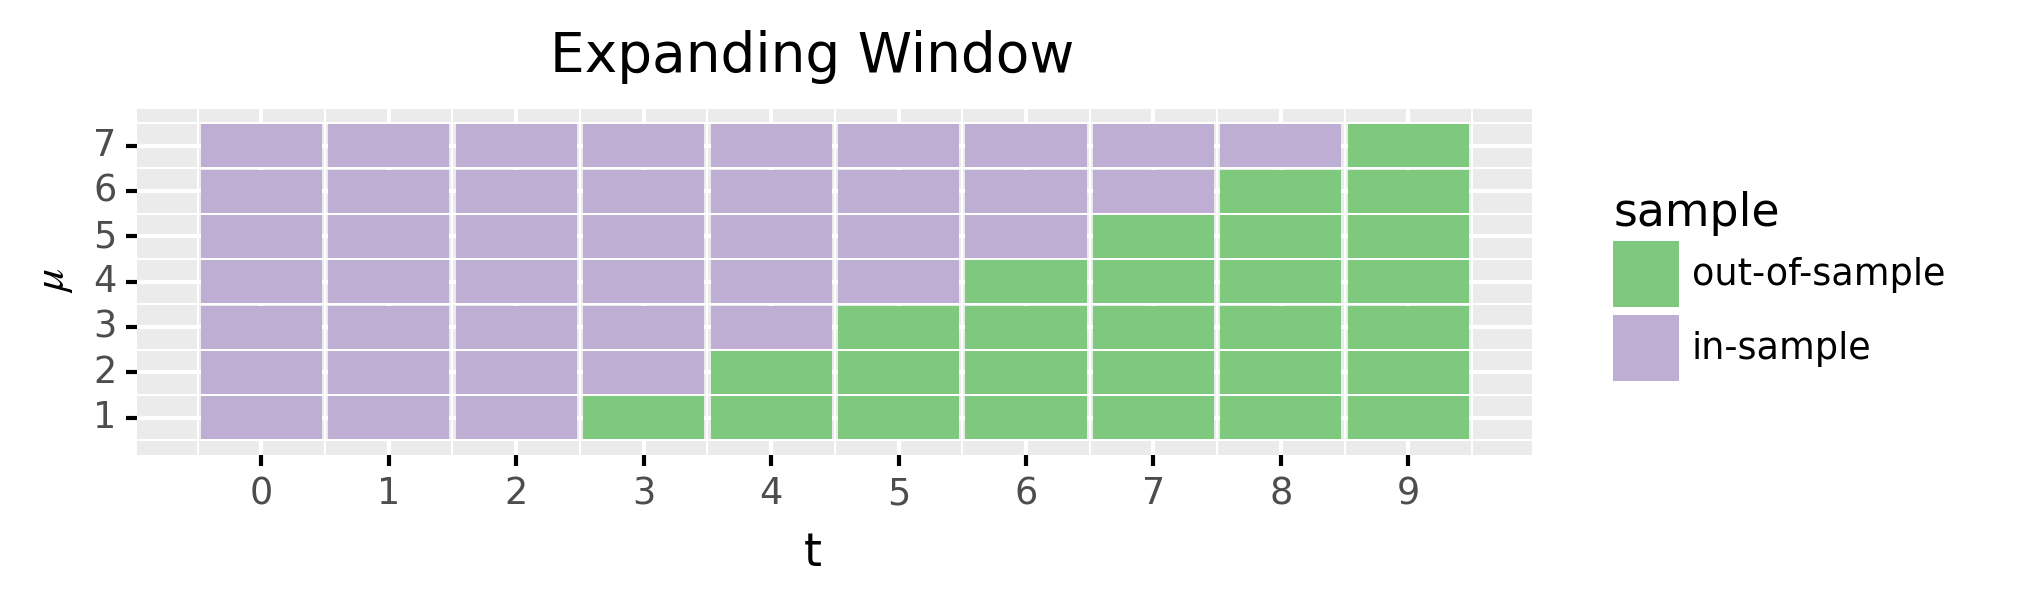

In [13]:
from plotnine import ggtitle

s = 1
alpha = 2
T = 10
max_mu = int((T - 1 + 1 - alpha) / s)

(
    ggplot(aes("t", r"$\mu$", "sample"))
    + [
        geom_tile(
            os_sample_block_e(mu, s, alpha, T),
            aes(width=0.95, height=0.95, fill="sample"),
        )
        for mu in range(1, max_mu)
    ]
    + [
        geom_tile(
            in_sample_block_e(mu, s, alpha, T),
            aes(width=0.95, height=0.95, fill="sample"),
        )
        for mu in range(1, max_mu)
    ]
    + scale_x_continuous(breaks=range(T + 1))
    + scale_y_continuous(breaks=range(1, max_mu))
    + scale_fill_brewer(type="qual", palette="Accent")
    + ggtitle("Expanding Window")
).draw();

Note that in-sample and out-of-sample never overlap in time for the same value of $\mu$. This is important because it helps keep our out-of-sample period out-of-sample. We do not want a situation where we *think* we are performing an out-of-sample forecast but actually the model was trained on some of the supposedly out-of-sample data.

### The Likely Best Possible Expanding Window Forecast

When we are assessing the potential of a model, we want to know i) how it would perform in practice and ii) that we are testing the best version of it possible. To address both of these points, we need to make a choice from the possible out-of-sample predictions because we have several for the same value of $t$:

- $|\mu|$ out-of-sample prediction models for $t=T-1$
- $|\mu|-1$ out-of-sample prediction models for $t=T-2$
- and so on...

To choose which of our out-of-sample predictions when we have multiple ones to choose from, we create the *union* of step ahead out-of-sample forecasts. Step ahead because that's what will likely be the best forecast (as opposed to many steps ahead) while still being out-of-sample. Because there are no *guarantees* which out-of-sample forecast will be best, it might be more accurate to call this the *preferred* or *one-step ahead* out-of-sample expanding forecast. For each possible value of $t$, this is the out-of-sample prediction with the highest possible value of $\mu$:

$$
\mathcal{O}^{e} = \bigcup_\mu  \bigg\{ f_\mu\left(O_\mu^e(X)\right) \bigg\}_{t=\mu s+ \alpha }^{t=(\mu+1)s -1+ \alpha}
$$

in the diagram above, it's the longest diagonal of out-of-sample predictions. Equivalently, the out-of-sample prediction set is composed of the first step of each test set indexed by $\mu$. In each case, these out-of-sample predictions are likely to be better than ones for other values of $\mu$ because they are trained on models that are closer in time to the value that is being predicted.

Let's work this out using code too. First, we define a function that, given a data frame with a time index as defined earlier, can return the out-of-sample rows. We know this ranges from $\mu \cdot s + \alpha$ to $T-1$ (inclusive), so will become `range(mu * s + alpha, T, step_size)` inside the function:

In [14]:
step_size = 1
alpha = 2
window_size = alpha + step_size
T = 10
max_mu = int((T - 1 + 1 - alpha) / step_size)


def os_sample_block_e(mu, step_size, alpha, T):
    """Returns the times within the $mu$th block of an expanding window (out-of-sample)"""
    xf = pd.DataFrame({"t": np.arange(mu * s + alpha, T, step_size)})
    xf[r"$\mu$"] = [mu] * (T - (mu * s + alpha))
    xf["sample"] = "out-of-sample"
    return xf

Next, we create the union of best predictions, which will always be the last time step in ascending order of $\mu$:

In [15]:
# iterate over increasing values of mu
script_O_e = pd.concat(
    [os_sample_block_e(mu, s, alpha, T) for mu in range(1, max_mu)], axis=0
)
script_O_e = script_O_e.reset_index(drop=True)
script_O_e["Preferred Prediction"] = False
# Drop any duplicates of timesteps, keeping only the last entry (which will have highest mu)
script_O_e.loc[
    script_O_e[~script_O_e["t"].duplicated(keep="last")].index, "Preferred Prediction"
] = True
script_O_e

,t,$\mu$,sample,Preferred Prediction
0,3,1,out-of-sample,True
1,4,1,out-of-sample,False
2,5,1,out-of-sample,False
3,6,1,out-of-sample,False
4,7,1,out-of-sample,False
...,...,...,...,...
23,8,5,out-of-sample,False
24,9,5,out-of-sample,False
25,8,6,out-of-sample,True
26,9,6,out-of-sample,False


Now we can plot the pattern of predictions we'd like to use as a function of $\mu$:

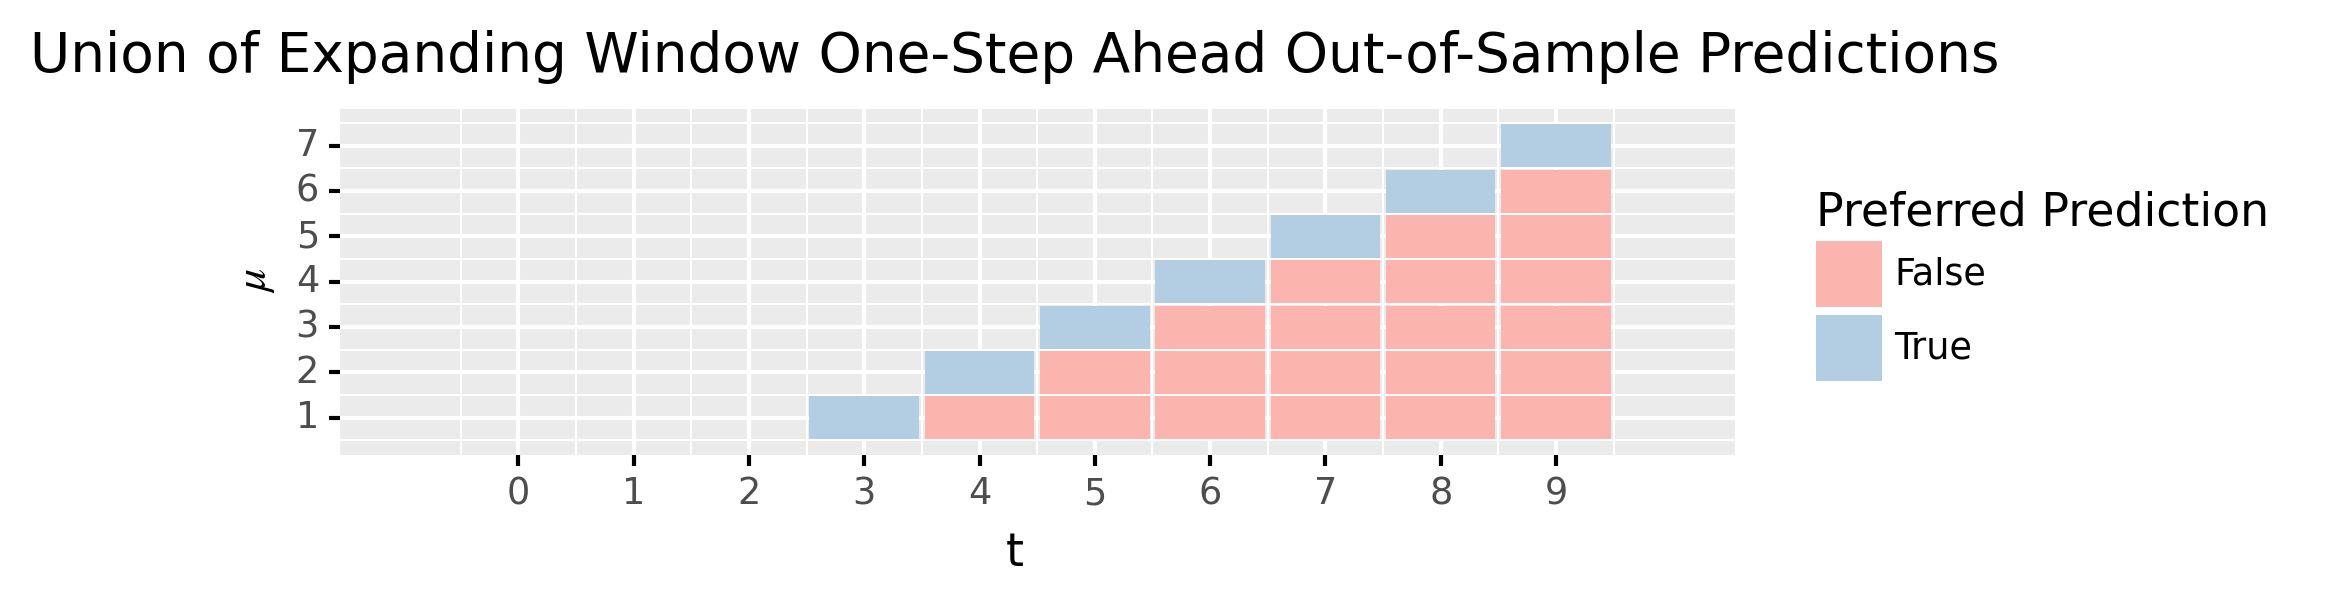

In [16]:
(
    ggplot(aes("t", r"$\mu$", "Union"))
    + geom_tile(script_O_e, aes(width=0.95, height=0.95, fill="Preferred Prediction"))
    + scale_x_continuous(breaks=range(T), limits=(-1, T))
    + scale_y_continuous(breaks=range(1, max_mu))
    + scale_fill_brewer(type="qual", palette="Pastel1")
    + ggtitle("Union of Expanding Window One-Step Ahead Out-of-Sample Predictions")
).draw();

The series in blue above is the one that we would use to compare against real data out-of-sample: it is the best *set* of predictions we are likely to make out-of-sample.

Of course, it's easy to create a set of in-sample preferred predictions by analogy. These are less interesting but follow the same principle of taking the time steps with the highest numbered value of $\mu$ available. In this special case of an expanding window, that's just going to be all of the predictions in the final $\mu$. The expression is

$$
\mathcal{I}^{e} = \bigcup_\mu \bigg\{ f_\mu\left(I_\mu^e(X)\right)\bigg\}_{t=(\mu -1) s + \alpha}^{t=\mu s -1+\alpha}
$$

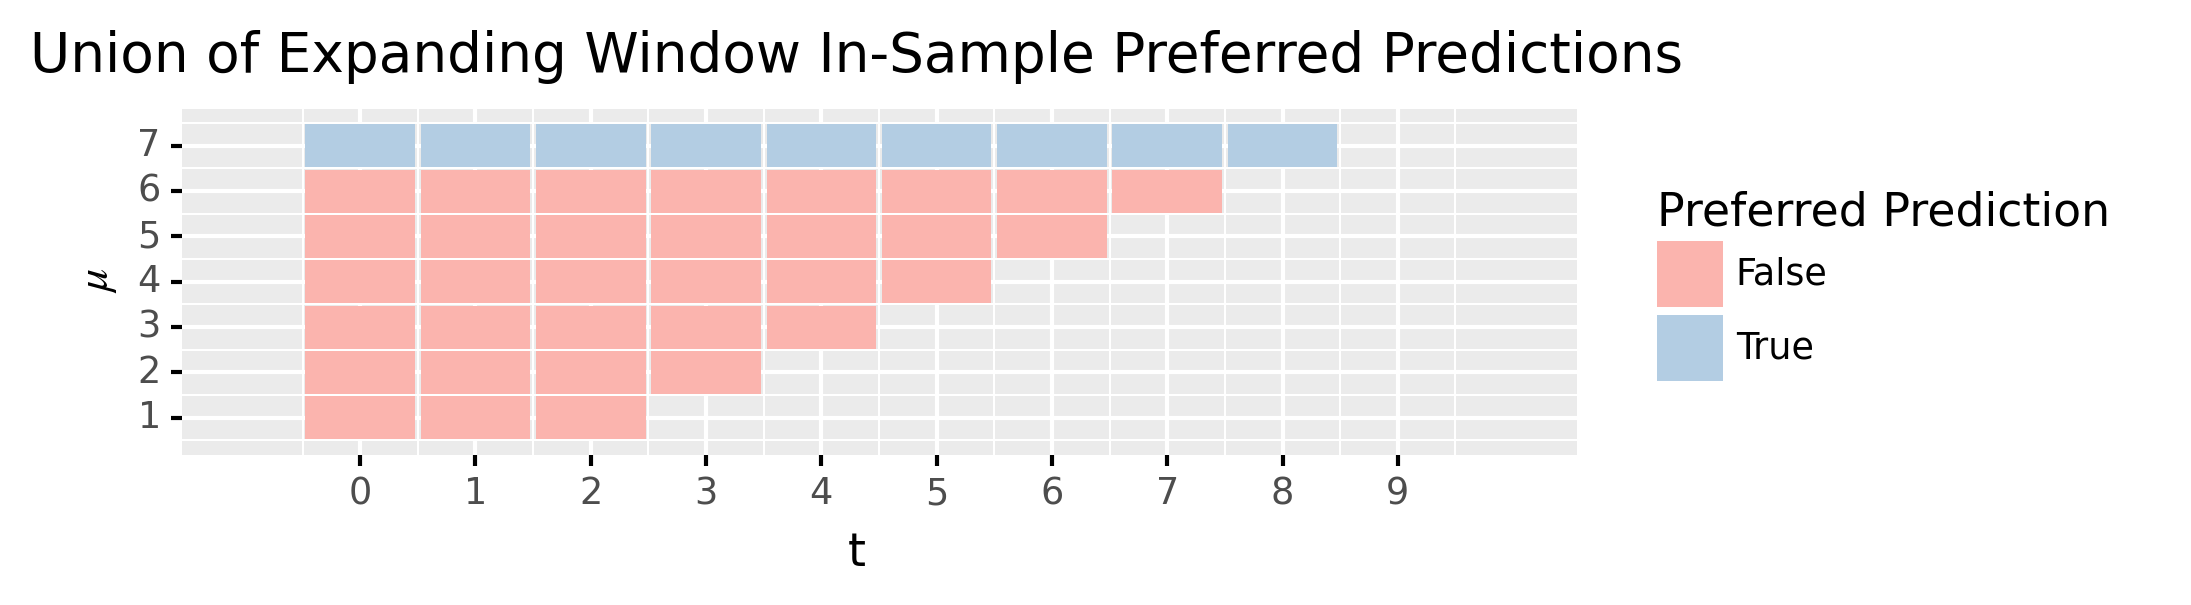

In [17]:
def in_sample_block_e(mu, step_size, alpha, T):
    """Returns the times within the $mu$th block of an expanding window (in-sample)"""
    xf = pd.DataFrame({"t": np.arange(0, mu * s + alpha, step_size)})
    xf[r"$\mu$"] = [mu] * (mu * s + alpha - 0)
    xf["sample"] = "in-sample"
    return xf


script_I_e = pd.concat(
    [in_sample_block_e(mu, s, alpha, T) for mu in range(1, max_mu)], axis=0
)
script_I_e = script_I_e.reset_index()
script_I_e["Preferred Prediction"] = False
script_I_e.loc[
    script_I_e[~script_I_e["t"].duplicated(keep="last")].index, "Preferred Prediction"
] = True

# Plot the union of expanding window in-sample predictions:
(
    ggplot(aes("t", r"$\mu$", "Union"))
    + geom_tile(script_I_e, aes(width=0.95, height=0.95, fill="Preferred Prediction"))
    + scale_x_continuous(breaks=range(T), limits=(-1, T))
    + scale_y_continuous(breaks=range(1, max_mu))
    + scale_fill_brewer(type="qual", palette="Pastel1")
    + ggtitle("Union of Expanding Window In-Sample Preferred Predictions")
).draw();

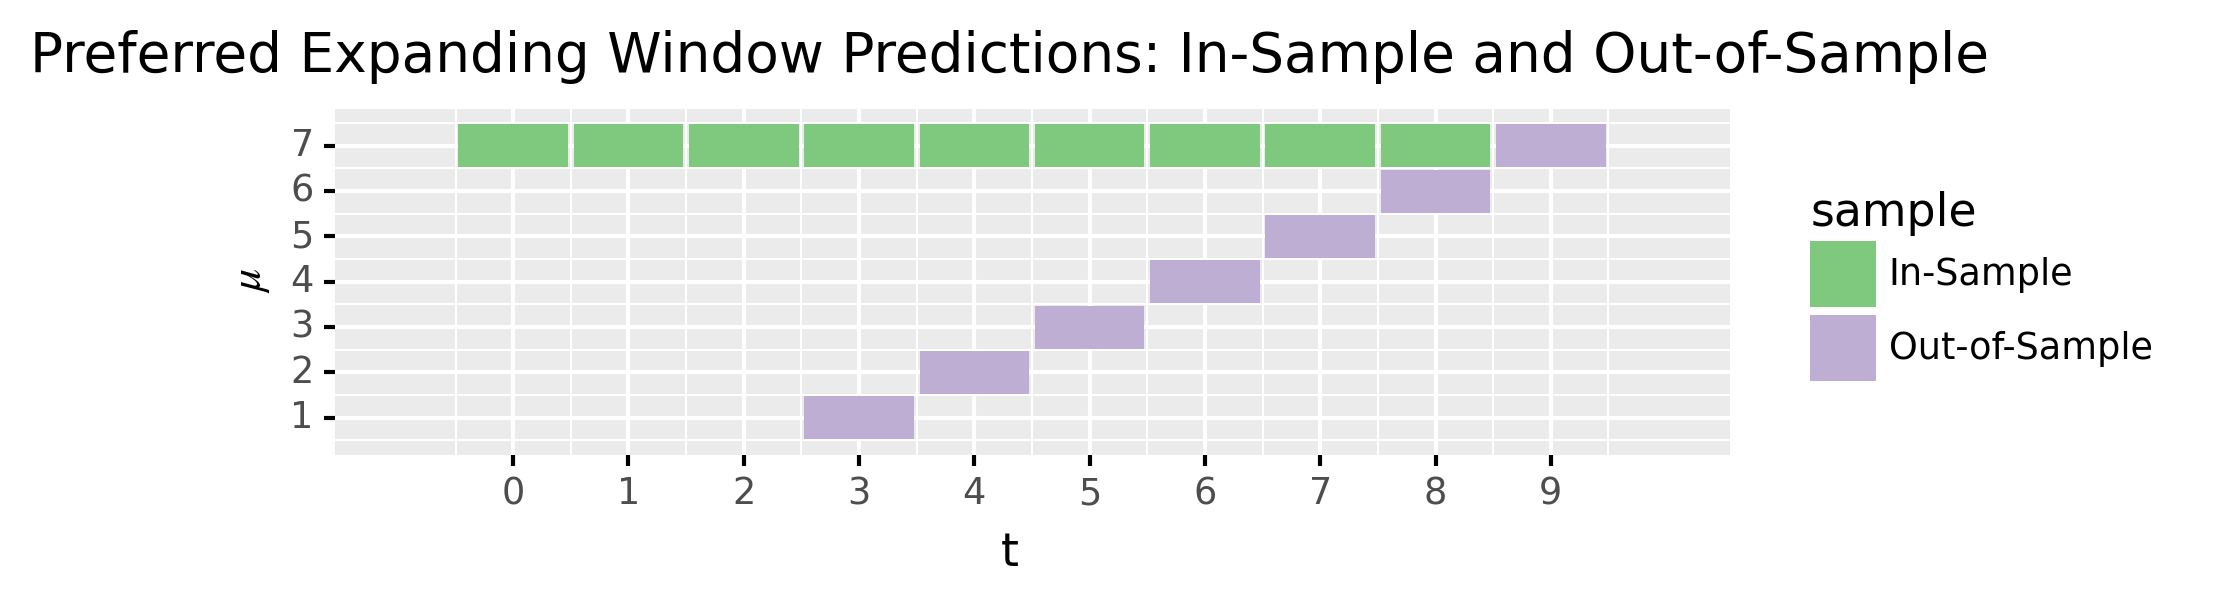

In [18]:
# TODO hide all
# For completeness, this is what the IS and OS time series look like next to each other:

script_I_e["sample"] = "In-Sample"
script_O_e["sample"] = "Out-of-Sample"
script_rolling = pd.concat([script_I_e, script_O_e], axis=0)
script_rolling = script_rolling[script_rolling["Preferred Prediction"] == True]

(
    ggplot(aes("t", r"$\mu$", "sample"))
    + geom_tile(script_rolling, aes(width=0.95, height=0.95, fill="sample"))
    + scale_x_continuous(breaks=range(T), limits=(-1, T))
    + scale_y_continuous(breaks=range(1, max_mu))
    + scale_fill_brewer(type="qual", palette="Accent")
    + ggtitle("Preferred Expanding Window Predictions: In-Sample and Out-of-Sample")
).draw();

## Rolling Window

In a rolling window forecast exercise, multiple forecasts are made. In each, the in-sample period *moves* (rather than grows) over time. Necessarily (given finite data), the out-of-sample period shrinks over time as the exercise progresses through different window configurations.

We index the different forecasts (synoymous with different models $f_\mu$) by $\mu$. The starting size of the window will be $s + \alpha$ where $s$ is the step size and $\alpha$ is a parameter that adjusts window size. For arbitrary $z_t$, the $\mu$th in-sample slice of time series data is: 

$$
I^r_{\mu}(\vec{z}) = \bigg\{ z_{t} \bigg\}_{t=(\mu-1)\cdot s}^{t=\mu\cdot s+\alpha -1}
$$

Applied to the features, this is the slice that will be used to train (aka fit) model $f_\mu$.

Likewise, the out-of-sample set is:

$$
O^r_{\mu}(\vec{z}) = \bigg\{ z_{t} \bigg\}_{t=\mu\cdot s+\alpha}^{t=T} 
$$

Below is a visualisation of all the rolling window forecasts in a single forecasting exercise.

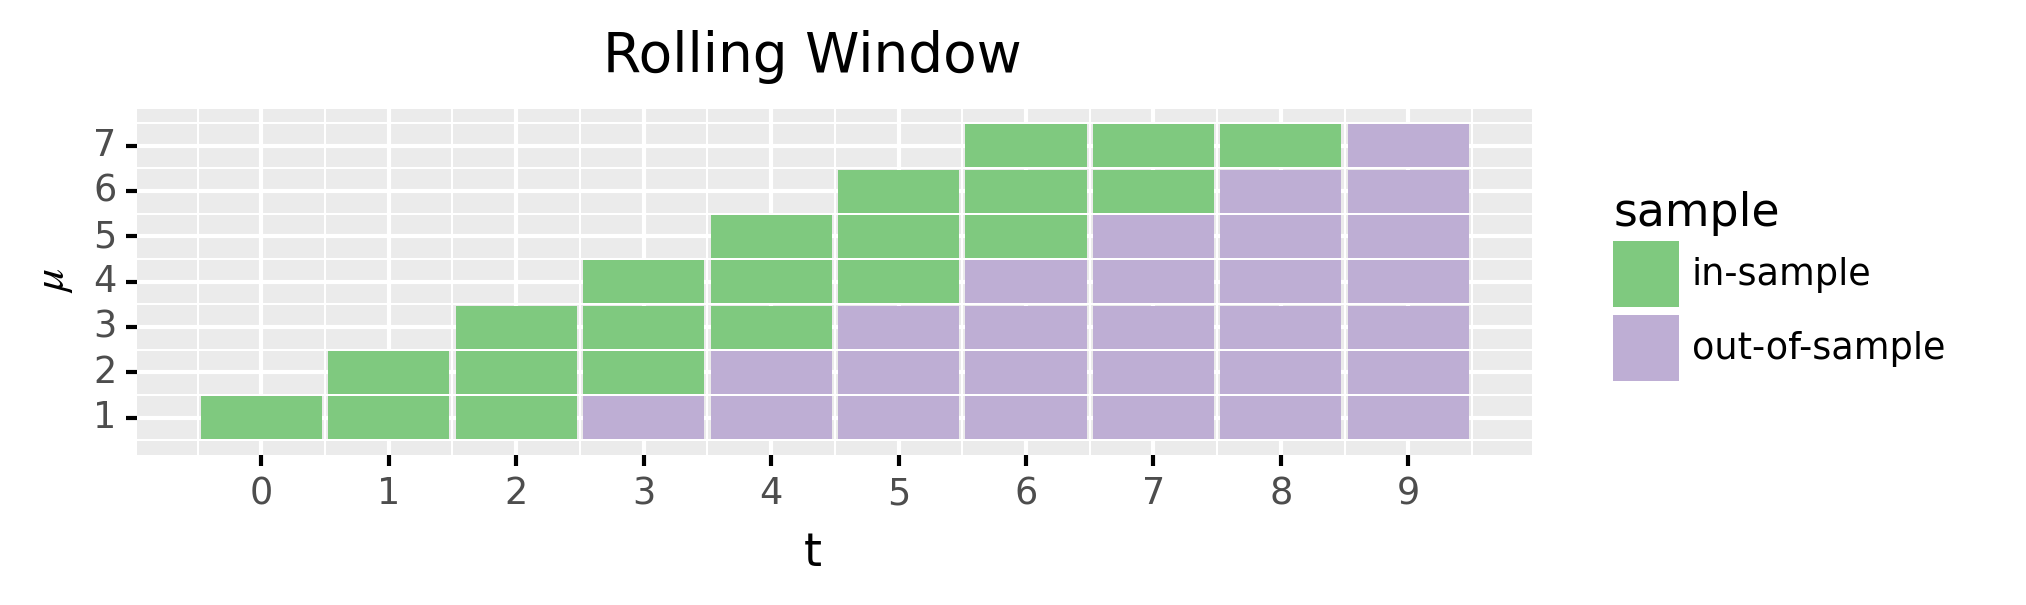

In [19]:
from plotnine import ggtitle

s = 1
alpha = 2
window_size = s + alpha
T = 10
max_mu = int((T - 1 + 1 - alpha) / s)

(
    ggplot(aes("t", r"$\mu$", "sample"))
    + [
        geom_tile(
            in_sample_block_r(mu, s, alpha, T),
            aes(width=0.95, height=0.95, fill="sample"),
        )
        for mu in range(1, max_mu)
    ]
    + [
        geom_tile(
            os_sample_block_r(mu, s, alpha, T),
            aes(width=0.95, height=0.95, fill="sample"),
        )
        for mu in range(1, max_mu)
    ]
    + scale_x_continuous(breaks=range(T + 1))
    + scale_y_continuous(breaks=range(1, max_mu))
    + scale_fill_brewer(type="qual", palette="Accent")
    + ggtitle("Rolling Window")
).draw();

### The Likely Best Possible Rolling Window Forecast

As with the expanding window, we want to know how models will perform in practice and that the best version of it is being assessed. To address both of these points, we need to make a choice from the possible out-of-sample predictions because we have several for the same value of $t$:

- $|\mu|$ out-of-sample prediction models for $t=T-1$
- $|\mu|-1$ out-of-sample prediction models for $t=T-2$
- and so on...

To do this we create the *union* of step ahead out-of-sample forecasts. Step ahead because that's what will likely be the best forecast (as opposed to many steps ahead) while still being out-of-sample. Because there are no *guarantees* which out-of-sample forecast will be best, it might be more accurate to call this the *preferred* or *one-step ahead* out-of-sample rolling window forecast. For each possible value of $t$, this is the out-of-sample prediction with the highest possible value of $\mu$:

$$
\mathcal{O}^{r} = \bigcup_\mu  \bigg\{ f_\mu\left(O_\mu^r(X)\right) \bigg\}_{t=\mu s+ \alpha }^{t=(\mu+1)s -1+ \alpha}
$$

in the diagram above, it's the longest diagonal of out-of-sample predictions. Equivalently, the out-of-sample prediction set is composed of the first step of each test set indexed by $\mu$. In each case, these out-of-sample predictions are likely to be better than ones for other values of $\mu$ because they are trained on models that are closer in time to the value that is being predicted.

Let's work this out using code too. First, we define function thats, given a data frame with a time index as defined earlier, can return the in-sample or out-of-sample rows. For out-of-sample, the slices range from $\mu\cdot s + \alpha$ to $T-1$ (inclusive), so will become `range(mu * s + alpha, T, step_size)` inside the function. Likewise, the inclusive/exclusive distinction applies to the in-sample slice, which will have `range((mu - 1) * s, mu * s + alpha, s)` for $(\mu-1)\cdot s$ to $\mu\cdot s+\alpha -1$.

In [20]:
def in_sample_block_r(mu, s, alpha, T):
    xf = pd.DataFrame({"t": np.arange((mu - 1) * s, mu * s + alpha, s)})
    xf[r"$\mu$"] = [mu] * (mu * s + alpha - (mu - 1) * s)
    xf["sample"] = "in-sample"
    return xf


def os_sample_block_r(mu, s, alpha, T):
    xf = pd.DataFrame({"t": np.arange(mu * s + alpha, T, s)})
    xf[r"$\mu$"] = [mu] * (T - (mu * s + alpha))
    xf["sample"] = "out-of-sample"
    return xf

Having defined these, we can compute the unions of best in- and out-of-sample predictions. For the expanding window case, we ended up repeating some of the same code. This is bad practice. We can do better by putting all of the common elements into a single function:

In [21]:
# Config:
s = 1
alpha = 2
window_size = s + alpha
T = 10


def return_rolling_union_of_slices(s, alpha, T, out_of_sample):
    """
    Returns a dataframe explaining where the best in-sample or out-of-sample forecasts are
    for a a given stepsize (s), alpha (=windowsize-s), and total number of time steps of
    the data (T).
    """
    if out_of_sample == True:
        slice_function = os_sample_block_r
        keep_string = "last"
    elif out_of_sample == False:
        slice_function = in_sample_block_r
        keep_string = "first"
    else:
        raise ValueError("out_of_sample must be True or False (and of type bool).")

    max_mu = int((T - 1 + 1 - alpha) / s)
    union = pd.concat(
        [slice_function(mu, s, alpha, T) for mu in range(1, max_mu)], axis=0
    )
    union = union.reset_index(drop=True)
    union["Preferred Prediction"] = False
    union.loc[
        union[~union["t"].duplicated(keep=keep_string)].index, "Preferred Prediction"
    ] = True
    return union


script_I_r = return_rolling_union_of_slices(s, alpha, T, out_of_sample=False)
script_O_r = return_rolling_union_of_slices(s, alpha, T, out_of_sample=True)
script_O_r.head()

,t,$\mu$,sample,Preferred Prediction
0,3,1,out-of-sample,True
1,4,1,out-of-sample,False
2,5,1,out-of-sample,False
3,6,1,out-of-sample,False
4,7,1,out-of-sample,False


Let's plot the union of best rolling out-of-sample predictions:

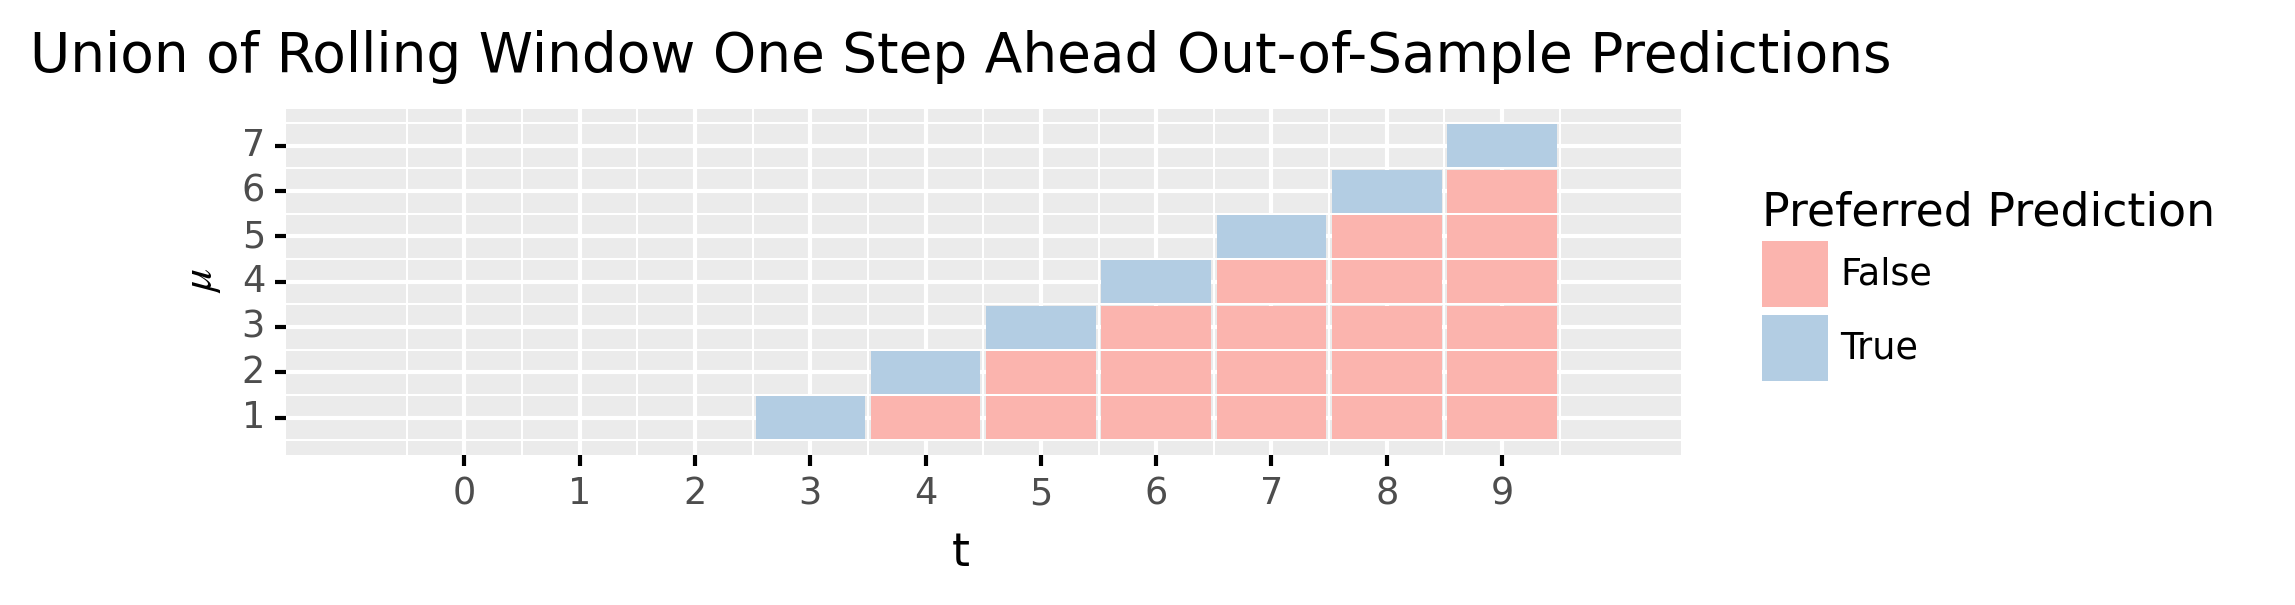

In [22]:
(
    ggplot(aes("t", r"$\mu$", "Preferred Prediction"))
    + geom_tile(script_O_r, aes(width=0.95, height=0.95, fill="Preferred Prediction"))
    + scale_x_continuous(breaks=range(T), limits=(-1, T))
    + scale_y_continuous(breaks=range(1, max_mu))
    + scale_fill_brewer(type="qual", palette="Pastel1")
    + ggtitle("Union of Rolling Window One Step Ahead Out-of-Sample Predictions")
).draw();

And the equivalent for in-sample predictions:

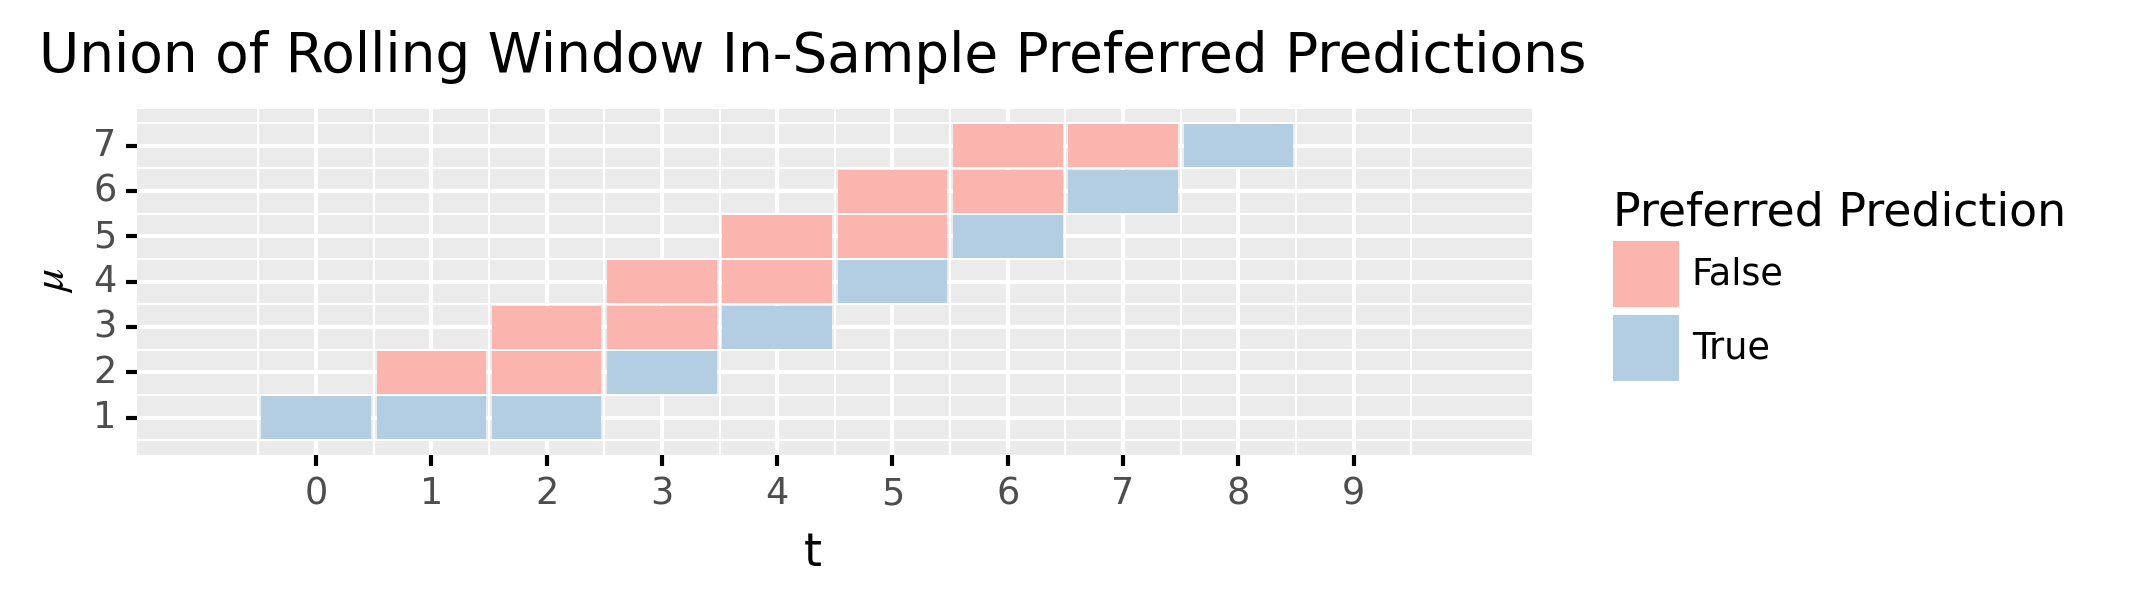

In [23]:
(
    ggplot(aes("t", r"$\mu$", "Preferred Prediction"))
    + geom_tile(script_I_r, aes(width=0.95, height=0.95, fill="Preferred Prediction"))
    + scale_x_continuous(breaks=range(T), limits=(-1, T))
    + scale_y_continuous(breaks=range(1, max_mu))
    + scale_fill_brewer(type="qual", palette="Pastel1")
    + ggtitle("Union of Rolling Window In-Sample Preferred Predictions")
).draw();

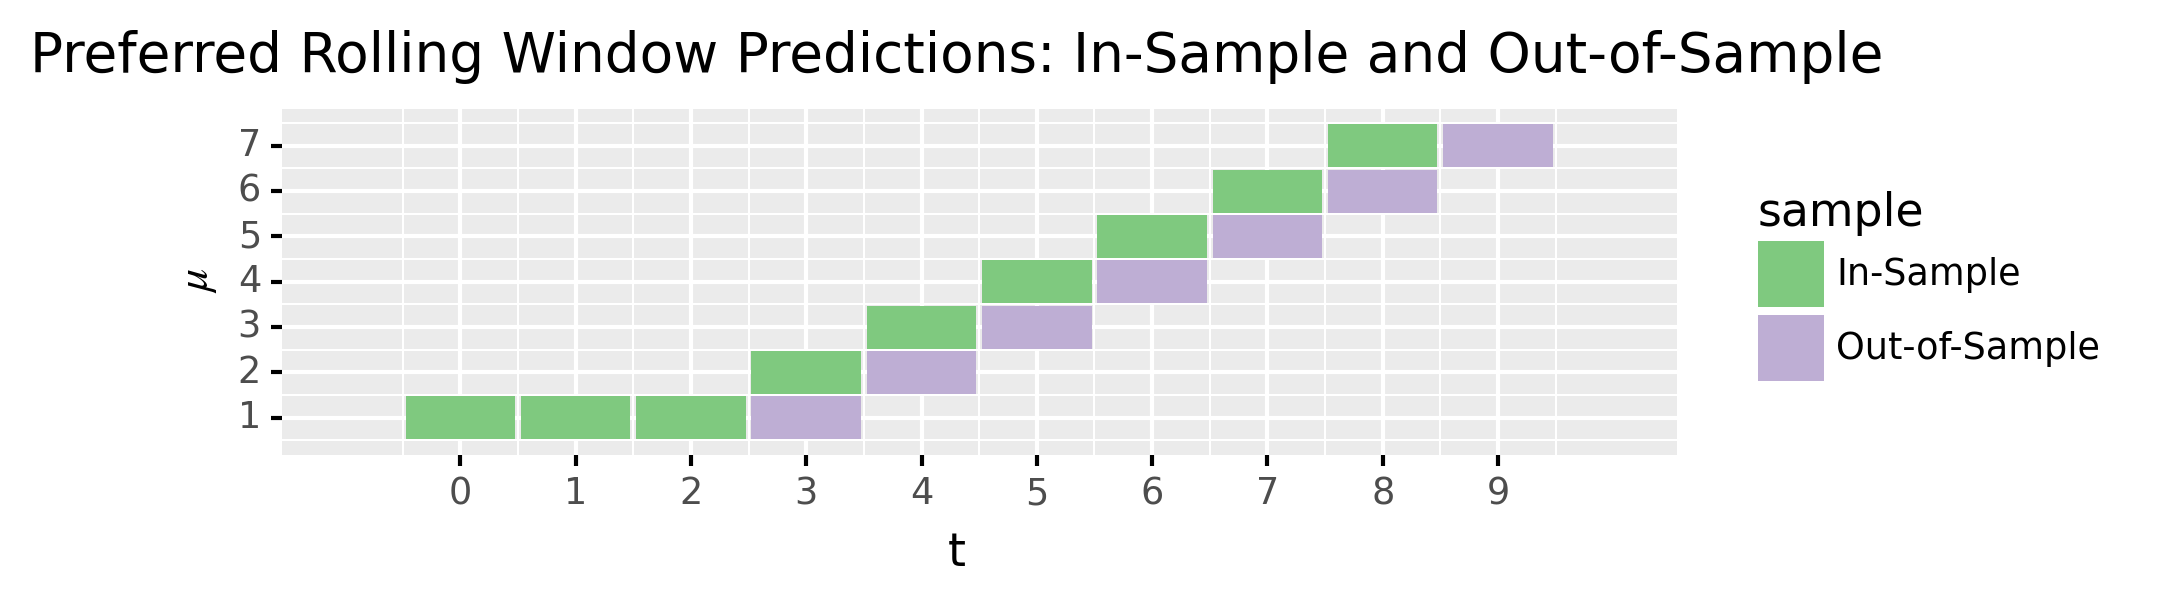

In [24]:
# TODO hide all
# For completeness, this is what the IS and OS time series look like next to each other:

script_I_r["sample"] = "In-Sample"
script_O_r["sample"] = "Out-of-Sample"
script_rolling = pd.concat([script_I_r, script_O_r], axis=0)
script_rolling = script_rolling[script_rolling["Preferred Prediction"] == True]

(
    ggplot(aes("t", r"$\mu$", "sample"))
    + geom_tile(script_rolling, aes(width=0.95, height=0.95, fill="sample"))
    + scale_x_continuous(breaks=range(T), limits=(-1, T))
    + scale_y_continuous(breaks=range(1, max_mu))
    + scale_fill_brewer(type="qual", palette="Accent")
    + ggtitle("Preferred Rolling Window Predictions: In-Sample and Out-of-Sample")
).draw();

## Transforms of Series in Forecasting Exercises

In practice, you often *don't* want to throw a time series straight into a forecast. This is for lots of reasons: stationarity, producing the best performing model, the ranges that certain models will accept, and so on. Instead you want to transform the data first using a general transform $T\colon X\to Z$. But when in a forecasting situation, extra care must be taken not to let information leak from the period that a model is *not* supposed to know about. For example, a forecast that is supposed to be out-of-sample, ie it is forecasting a time period $t''$, should not be able to see any information about $X_{t''}$ or $y_{t''}$. Why is this a problem when doing transforms? Because many transforms of, say, a scalar $x_t$ depend on $x_{t'}; \: t\neq t'$.

First, let's take an example of a common transform with no dependence on any other data: $T(x_t) = \ln(x_t)$. In this case we do not need to worry.

Another example that's quite common is $T(x_t) = \frac{x_t}{x_{t-1}}$. Again, this transform shouldn't cause us much concern because it only depends on *past* information.

Let's now turn to more tricky transforms. Let's imagine we wish to normalise the data, ie take

$$
T(x_t) = \frac{1}{\sigma_{x}} \left( x_t - \frac{\sum_{t'} x_{t'}}{\sum_{t'} t'} \right)
$$

where ${\displaystyle \sigma_{x}={\sqrt {{\frac {1}{\sum_{t'} x_t'}} \sum_{t'}\left(x_{t'}-{\frac{\sum_{t''} x_{t''}}{\sum_{t''} t''}}\right)^{2}}}}$. The summations are over *all* values of $t$, but this means that $T(x_t)$ has 'seen' $x_{t'}$, $t'>t$ and $t'$ may well be in the out-of-sample slice. This could be a problem: imagine that the mean or standard deviation changes significantly because of a crisis. Being privy to that shift may make it easier to predict post-crisis values of the target variable.

To fix information leakage due to transforms, we redefine transformations to make them a function of the windows being used in the forecasting exercise. For an expanding window transform of a variable $x_t$, this would be:

$$
T_{\mu}^e (\vec{x}) = T_{\mu}^e (\vec{x}; I_\mu^e(\vec{x})) = \frac{\vec{x} - \langle{I_\mu^e(\vec{x})\rangle}}{\sigma_{I_\mu^e(\vec{x})}} 
$$

where $\langle x \rangle$ is the mean of $\{x_t\}$. So now the transform is dependent on the *type* of forecasting exercise, the *period* ($\mu$) of the forecasting exercise, and the *input data*. A similar definition applies to the rolling window configuration.

How do we apply this in code? That part's easy: we can re-use the slice functions we made earlier, namely `in_sample_block_r` for in-sample rolling windows and `in_sample_block_e` for out-of-sample expanding windows. A more general way of avoiding data leakage, especially when there are many transformations, is to use **scikit-learn**'s [pipeline](https://scikit-learn.org/stable/modules/compose.html#pipeline) functionality.


## Data Vintage and the Real-Time Information Flow

There's another complication if you want an accurate assessment of how good your forecast will be in the real world: some data, and especially economic data, are revised over time. But to give an *accurate* picture of how well your forecast approach would have done at the time, you need to use only the data that would have been available at the time the forecast was made: you need to use real-time data vintages. Typically, one only considers different vintages of regressors--but target variables change too and this is worth bearing in mind if you are using lags.

A few labelling operations help us use everything defined so far in this chapter in the real-time data vintage case. We introduce an extra label for vintage, $\tau$, which says when the data were released. Features are now given by $x_{tk\tau}$. Assuming that vintages are improving over time, models will always be trained using the most up-to-date vintage available up to that time so that a forecast made at $t$ uses the highest available value of $\tau$ for which $\tau \leq t$, eg $\tau = \max{ \{ \tau' | \tau' \leq t \}}$.